In [1]:
!python --version

Python 3.7.13


In [2]:
!pip install pylenm==0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Basics
import os
import inspect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, datetime

# PyLenm
import pylenm as plm
print("pylenm version: ", plm.__version__)
from pylenm import PylenmDataFactory

# GIS data layers
from pyproj import Transformer

# download graphs
from google.colab import files

pylenm version:  0.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls /content/drive/MyDrive/Python/data/Shiprock_Precip_Data/

ERA5_Shiprock_36.77_-108.684.csv


In [6]:
# Google File Pathing
filename = '/content/drive/MyDrive/Python/data/Shiprock_Floodplain.xlsx'
p_filename = '/content/drive/MyDrive/Python/data/Shiprock_Precip_Data/ERA5_Shiprock_36.77_-108.684.csv'

In [7]:
# import the data

data = pd.read_excel(filename,usecols='B:G')
data = data.rename({'Location': 'STATION_ID', 'Date': 'COLLECTION_DATE', 'Parameter':'ANALYTE_NAME', 'Result': 'RESULT', 'Unit': 'RESULT_UNITS'}, axis=1)
##csv version: #data = data.rename({'Location   ': 'STATION_ID', 'Date       ': 'COLLECTION_DATE', 'Parameter          ':'ANALYTE_NAME', 'Result       ': 'RESULT', 'Unit   ': 'RESULT_UNITS'}, axis=1)

data.STATION_ID = data.STATION_ID.astype('object')


In [8]:
# Remove Analyte data for wells where all analytes were not collected

df = PylenmDataFactory(data)
df.simplify_data(inplace=True)

Analytes = data.ANALYTE_NAME.unique()

#nAnalytes = len(Analytes)

for a in Analytes:
  Analyte_details = df.get_analyte_details(a)
  all_wells = Analyte_details.index

  data = data[data.STATION_ID.isin(all_wells)]

  df = PylenmDataFactory(data)
  df.simplify_data(inplace=True)

Successfully imported the data!

Successfully imported the data!

Successfully imported the data!



In [9]:
# Append monthly precipitation data to data per well 
#    (there is probably a more space efficient way to make this work with pylenm, but as far as I can tell the precipitation data NEEDS to be assigned to each well for pylenm's correlation functions to work)

pdata = pd.read_csv(p_filename)
pdata = pdata.drop(['latitude', 'longitude','t2m'], axis=1)
pdata = pdata.rename({'time': 'COLLECTION_DATE', 'tp': 'RESULT'}, axis=1)
pdata['COLLECTION_DATE'] = pd.to_datetime(pdata['COLLECTION_DATE'])

# Determine the earliest start date necessary, remove earlier dates

startdate = '2022-01-01'
startdate = pd.to_datetime(startdate)

for a in Analytes:

  Analyte_details = df.get_analyte_details(a)
  if startdate > Analyte_details['Start Date'].min():
    startdate = Analyte_details['Start Date'].min()

startdate = pd.to_datetime(startdate)
pdata = pdata[pdata.COLLECTION_DATE > startdate]

# Make a data table of the Precipitation data per well, and append it

all_wells = Analyte_details.index

for a in all_wells:
  pframe = pd.DataFrame({'STATION_ID':a,'COLLECTION_DATE':pdata['COLLECTION_DATE'],'CAS':'PRCP','ANALYTE_NAME':'Precipitation','RESULT':pdata['RESULT'],'RESULT_UNITS':'ft'})
  # not sure if the units are actually feet, but I don't think that matters for purposes of correlation

  data = pd.concat([data,pframe],ignore_index=True) 

data['STATION_ID'] = data['STATION_ID'].astype(int)
data['STATION_ID'] = data['STATION_ID'].astype(str)

df = PylenmDataFactory(data)
df.simplify_data(inplace=True)


Successfully imported the data!



,COLLECTION_DATE,STATION_ID,ANALYTE_NAME,RESULT,RESULT_UNITS
0,1985-10-01 12:00:00,1128,Precipitation,0.00,ft
1,1985-10-01 12:00:00,1089,Precipitation,0.00,ft
2,1985-10-01 12:00:00,793,Precipitation,0.00,ft
3,1985-10-01 12:00:00,1104,Precipitation,0.00,ft
4,1985-10-01 12:00:00,617,Precipitation,0.00,ft
...,...,...,...,...,...
164794,2022-03-28 12:00:00,1009,WaterElevation,4887.75,ft
164795,2022-03-28 12:00:00,1140,WaterElevation,4887.38,ft
164796,2022-03-28 12:00:00,1089,WaterElevation,4883.60,ft
164797,2022-03-28 12:00:00,1111,WaterElevation,4887.43,ft


In [10]:
# Division of Wells by Sector

Downfar = ['799', '850', '851', '852', '797']
Downacc = ['732']
Downclose = ['735', '1127', '1130', '1129', '1131', '1125', '1126', '1127', '1117', '1132', '1134', '1126', '1128', '1116', '1133', '1115', '1114', '608', '1062', '863', '862', '609', '1113', '610', '611', '773', '612', '858', '859', '614', '1000', '1001', '613', '1142']

Upfar = ['784', '783', '782', '734', '856', '855', '1143', '630', '629', '628', '627', '736', '1135']
Upacc = ['631', '632', '733']
Upclose = ['626', '625', '624', '623', '1137', '1138', '1139', '1089', '766', '1075', '1104', '854', '1077', '1008', '775', '619', '768', '622', '621', '620', '798', '1136', '792', '617', '618', '779', '793', '1111', '1140', '615', '861', '1105', '860', '1112', '1141', '1009', '794', '795', '1013', '853', '857']

In [11]:
# Viewable Data Summaries

GWE_details = df.get_analyte_details('WaterElevation')
U_details = df.get_analyte_details('Uranium')
P_details = df.get_analyte_details('Precipitation')

Raw Comparison Figures

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.



     Well  1135  data comparison

     This well is far upstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

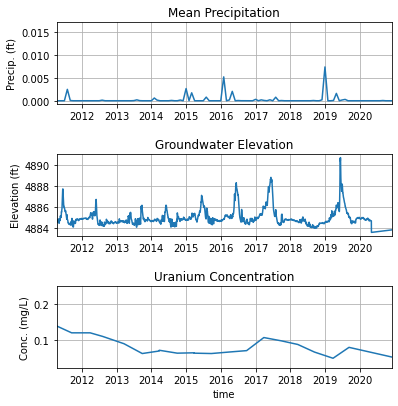




     Well  1136  data comparison

     This well is close upstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

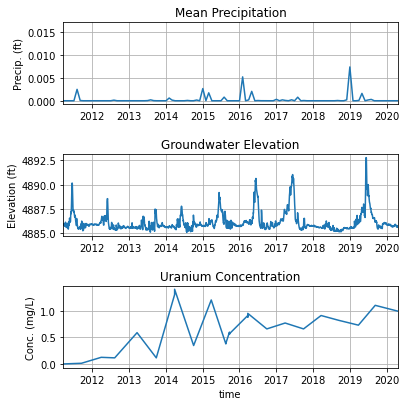




     Well  1128  data comparison

     This well is close downstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

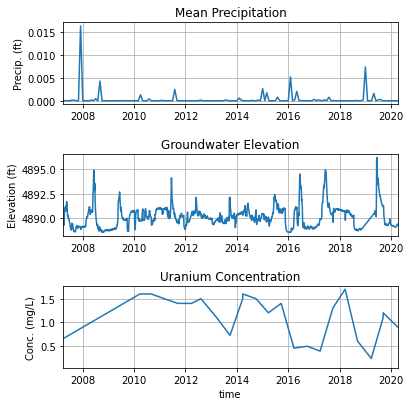

In [12]:
# Graph Analytes in Subplots

all_wells = data['STATION_ID'].unique()
desired_wells = ['1135','1136','1128']

Analytes = data['ANALYTE_NAME'].unique()

for well_name in desired_wells:

  ELEV_data = df.query_data(well_name,'WaterElevation')
  ELEV_data = df.simplify_data(data=ELEV_data)
  ELEV_data['COLLECTION_DATE'] = pd.to_datetime(ELEV_data['COLLECTION_DATE'])


  URAN_data = df.query_data(well_name, 'Uranium')
  URAN_data = df.simplify_data(data=URAN_data)
  URAN_data['COLLECTION_DATE'] = pd.to_datetime(URAN_data['COLLECTION_DATE'])
  

  PRCP_data = df.query_data(well_name, 'Precipitation')
  PRCP_data = df.simplify_data(data=PRCP_data)
  PRCP_data['COLLECTION_DATE'] = pd.to_datetime(PRCP_data['COLLECTION_DATE'])


  ELEVstart = ELEV_data['COLLECTION_DATE'].iat[0]
  ELEVend = ELEV_data['COLLECTION_DATE'].iat[-1]

  URANstart = URAN_data['COLLECTION_DATE'].iat[0]
  URANend = URAN_data['COLLECTION_DATE'].iat[-1]

  PRCPstart = PRCP_data['COLLECTION_DATE'].iat[0]
  PRCPend = PRCP_data['COLLECTION_DATE'].iat[-1]

  # Select the latest start date, earliest end date

  dateframe = pd.DataFrame({'Start Date':[ELEVstart,URANstart,PRCPstart],'End Date':[ELEVend,URANend,PRCPend]})

  startdate = dateframe['Start Date'].max()
  enddate = dateframe['End Date'].min()

  if startdate >= enddate:
    print('Well ', well_name, ' is unworkable')
  else:
    print('\n     Well ', well_name, ' data comparison\n')

  if well_name in Downfar:
    print('     This well is far downstream\n')
  elif well_name in Downacc:
    print('     This well is downstream, and across\n')
  elif well_name in Downclose:
    print('     This well is close downstream\n')
  elif well_name in Upfar:
    print('     This well is far upstream\n')
  elif well_name in Upacc:
    print('     This well is upstream, and across\n')
  elif well_name in Upclose:
    print('     This well is close upstream\n')
  else:
    print('     Missed this one...')



  fig, axs = plt.subplots(3, 1)

  axs[0].title.set_text('Mean Precipitation')
  axs[0].plot(PRCP_data.COLLECTION_DATE, PRCP_data.RESULT)
  axs[0].set_xlim(startdate, enddate)
  #axs[0].set_xlabel('time')
  axs[0].set_ylabel('Precip. (ft)')
  axs[0].grid(True)

  axs[1].title.set_text('Groundwater Elevation')
  axs[1].plot(ELEV_data.COLLECTION_DATE, ELEV_data.RESULT)
  axs[1].set_xlim(startdate, enddate)
  #axs[1].set_xlabel('time')
  axs[1].set_ylabel('Elevation (ft)')
  axs[1].grid(True)
  
  axs[2].title.set_text('Uranium Concentration')
  axs[2].plot(URAN_data.COLLECTION_DATE, URAN_data.RESULT)
  axs[2].set_xlim(startdate, enddate)
  axs[2].set_xlabel('time')
  axs[2].set_ylabel('Conc. (mg/L)')
  axs[2].grid(True)



  plt.subplots_adjust(bottom = 0.1, top = 1.3, wspace=0.5, hspace=0.6)

  savepath = str(well_name)+'RawComparison.pdf'
  plt.savefig(savepath,bbox_inches='tight')
  files.download(savepath)

  plt.show()

  print('\n')


In [13]:
# Determine the proper number of lags

#Analytes = data['ANALYTE_NAME'].unique()

#lags = [5, 6, 7, 8, 9] #lag of 8 seems to solve most minor gaps
#shared_dates = df.getCommonDates(analytes=Analytes, lag=lags)

#colors = ['r', 'b', 'g', 'y', 'c']#, 'm', 'k', 'w']

#fig, axs = plt.subplots(nrows=1, ncols=5,figsize=(20,5), sharex=True, sharey=True)
#for i, ax in enumerate(axs):
#    Ldata = np.array(shared_dates[shared_dates.index.get_level_values('Lag')==lags[i]]['Number of wells'])
#    axs[i].plot(Ldata, color=colors[i], label='Lag of '+str(lags[i]))
#    axs[i].legend(loc="upper right")
#    axs[i].set_xlabel('Time series')
#    axs[i].set_ylabel('Number of wells')
#    stats_text = str('Number of wells stats:\nMIN: {}\nMEAN: {}\nMAX: {}'.format(Ldata.min(), round(Ldata.mean(), 2), Ldata.max()))
#    axs[i].text(0.5,-0.4, stats_text, size=12, ha="center", transform=axs[i].transAxes)

In [14]:
#lag = 8
#jointData = df.getJointData(Analytes, lag=lag)

In [15]:
# Function Fom Pylenm, slightly adjusted

### NOT WRITTEN BY JEREMY, CREDIT TO AURELIAN MERAY ###

import seaborn as sns

def plot_corr_by_well(self, well_name, analytes, remove_outliers=True, z_threshold=4, interpolate=False, frequency='2W', save_dir='plot_correlation', log_transform=False, fontsize=20, returnData=False, remove=[], no_log=None):
        """Plots the correlations with the physical plots as well as the correlations of the important analytes over time for a specified well.

        Args:
            well_name (str): name of the well to be processed
            analytes (list): list of analyte names to use
            remove_outliers (bool, optional): choose whether or to remove the outliers. Defaults to True.
            z_threshold (int, optional): z_score threshold to eliminate outliers. Defaults to 4.
            interpolate (bool, optional): choose whether or to interpolate the data. Defaults to False.
            frequency (str, optional): {‘D’, ‘W’, ‘M’, ‘Y’} frequency to interpolate. Note: See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html for valid frequency inputs. (e.g. ‘W’ = every week, ‘D ’= every day, ‘2W’ = every 2 weeks). Defaults to '2W'.
            save_dir (str, optional): name of the directory you want to save the plot to. Defaults to 'plot_correlation'.
            log_transform (bool, optional): flag for log base 10 transformation. Defaults to False.
            fontsize (int, optional): font size. Defaults to 20.
            returnData (bool, optional): flag to return data used to perfrom correlation analysis. Defaults to False.
            remove (list, optional): wells to remove. Defaults to [].
            no_log (list, optional): list of column names to not apply log transformation to. Defaults to None.

        Returns:
            None
        """
        data = self.data
        query = data[data.STATION_ID == well_name]
        a = list(np.unique(query.ANALYTE_NAME.values))# get all analytes from dataset
        for value in analytes:
            if((value in a)==False):
                return 'ERROR: No analyte named "{}" in data.'.format(value)
        analytes = sorted(analytes)
        query = query.loc[query.ANALYTE_NAME.isin(analytes)]
        x = query[['COLLECTION_DATE', 'ANALYTE_NAME']]
        unique = ~x.duplicated()
        query = query[unique]
        piv = query.reset_index().pivot(index='COLLECTION_DATE',columns='ANALYTE_NAME', values='RESULT')
        piv = piv[analytes]
        piv.index = pd.to_datetime(piv.index)
        totalSamples = piv.shape[0]
        piv = piv.dropna()
        if(interpolate):
            piv = self.interpolate_well_data(well_name, analytes, frequency=frequency)
            file_extension = '_interpolated_' + frequency
            title = well_name + '_correlation - interpolated every ' + frequency
        else:
            file_extension = '_correlation'
            title = well_name + '_correlation'
        samples = piv.shape[0]
        if(samples < 5):
            if(interpolate):
                return 'ERROR: {} does not have enough samples to plot.\n Try a different interpolation frequency'.format(well_name)
            return 'ERROR: {} does not have enough samples to plot.'.format(well_name)
        else:
            # scaler = StandardScaler()
            # pivScaled = scaler.fit_transform(piv)
            # pivScaled = pd.DataFrame(pivScaled, columns=piv.columns)
            # pivScaled.index = piv.index
            # piv = pivScaled
            
            if(log_transform):
                piv[piv <= 0] = 0.00000001
                temp = piv.copy()
                piv = np.log10(piv)
                if(no_log !=None):
                    for col in no_log:
                        piv[col] = temp[col]

            # Remove outliers
            if(remove_outliers):
                piv = self.remove_outliers(piv, z_threshold=z_threshold)
            samples = piv.shape[0]

            idx = piv.index.date
            dates = [dates.strftime('%Y-%m-%d') for dates in idx]
            remaining = [i for i in dates if i not in remove]
            piv = piv.loc[remaining]
            
            sns.set_style("white", {"axes.facecolor": "0.95"})
            g = sns.PairGrid(piv, aspect=1.2, diag_sharey=False, despine=False)
            g.fig.suptitle(title, fontweight='bold', y=1.08, fontsize=25)
            g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'red', 'lw': 3},
                                                            scatter_kws={'color': 'black', 's': 20})
            g.map_diag(sns.distplot, kde_kws={'color': 'black', 'lw': 3}, hist_kws={'histtype': 'bar', 'lw': 2, 'edgecolor': 'k', 'facecolor':'grey'})
            g.map_upper(self.__plotUpperHalf)

            #for ax in g.axes.flat:
            #    ax.tick_params("y", labelrotation=0, labelsize=fontsize)
            #    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=fontsize)
            #    ax.set_xlabel(ax.get_xlabel(), fontsize=fontsize, fontweight='bold') #HERE
            #    ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize,fontweight='bold')
                
            g.fig.subplots_adjust(wspace=0.3, hspace=0.3)
            ax = plt.gca()

            props = dict(boxstyle='round', facecolor='grey', alpha=0.15)
            ax.text(1.3, 6.2, 'Start date:  {}\nEnd date:    {}\n\nOriginal samples:     {}\nSamples used:     {}'.format(piv.index[0].date(), piv.index[-1].date(), totalSamples, samples), transform=ax.transAxes, fontsize=20, fontweight='bold', verticalalignment='bottom', bbox=props)
            # Add titles to the diagonal axes/subplots
            for ax, col in zip(np.diag(g.axes), piv.columns):
                ax.set_title(col, y=0.82, fontsize=15)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            g.fig.savefig(save_dir + '/' + well_name + file_extension + '.png', bbox_inches="tight")
            if(returnData):
                return piv

In [16]:
#df = PylenmDataFactory(data)
#df.simplify_data(inplace=True)

#all_wells = data['STATION_ID'].unique()
#Analytes = data['ANALYTE_NAME'].unique()

#for well_name in ['1135','1136','1128']:#all_wells.astype(str):
#  df.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)

In [27]:
# Determine the longest range of missing uranium collections per well

# trimming data to avoid these large gaps might make the data more suitable to interpolation

Analyte = 'Uranium' #change this if desired, probably very inefficient for larger datasets

for w in all_wells:

  mask = (data['ANALYTE_NAME'] == Analyte) & (data['STATION_ID'] == w)
  tempframe = data[mask]
  
  delta = 0

  for i in range(0,len(tempframe)-2):

    f_date = tempframe['COLLECTION_DATE'].iat[i]
    l_date = tempframe['COLLECTION_DATE'].iat[i+1]

    if ((l_date - f_date).days) > delta:
      delta = (l_date - f_date).days
      rf_date = f_date.date()
      rl_date = l_date.date()

  print('The longest gap in well', w, Analyte, 'data is', delta, 'days between', rf_date, 'and', rl_date, '  The full data range stretches between', tempframe['COLLECTION_DATE'].iat[0], 'and', tempframe['COLLECTION_DATE'].iat[-1])

The longest gap in well 617 Uranium data is 1046 days between 1993-02-22 and 1996-01-04   The full data range stretches between 1985-10-01 12:00:00 and 2008-01-23 12:00:00
The longest gap in well 618 Uranium data is 4508 days between 1988-10-11 and 2001-02-13   The full data range stretches between 1985-10-01 12:00:00 and 2022-03-23 12:00:00
The longest gap in well 735 Uranium data is 761 days between 1996-01-04 and 1998-02-03   The full data range stretches between 1993-04-24 12:00:00 and 2022-03-22 12:00:00
The longest gap in well 736 Uranium data is 742 days between 2019-09-11 and 2021-09-22   The full data range stretches between 1993-04-23 12:00:00 and 2022-03-24 12:00:00
The longest gap in well 766 Uranium data is 2535 days between 2001-02-13 and 2008-01-23   The full data range stretches between 2000-02-02 12:00:00 and 2022-03-21 12:00:00
The longest gap in well 779 Uranium data is 2535 days between 2001-02-13 and 2008-01-23   The full data range stretches between 2000-02-03 12:

In [ ]:
# Decompose PRECIP/ELEV/URAN from a clean data table into three separate dataframes, overall, seasonal, residual

#Analytes = data['ANALYTE_NAME'].unique()
#all_wells = df.get_analyte_details(Analytes[0]).index

# Filling missing dates is necessary, seasonal_decompose only considers entries as sequence, so the analysis of data with uneven frequency of measurement will not result in a proper trend

###CleanData = df.getCleanData(Analytes)
### I found a better way than this to fill missing dates in a dataset after moving on, see the next code block. That was written to fill missing daily entries though, so if your frequency of 
###    collection after processing/interpolation is any other spacing (weekly, monthly, quarterly, etc), it will have to be changed slightly to match.

#Overalldata = pd.DataFrame()
#Seasonaldata = pd.DataFrame()
#Residualdata = pd.DataFrame()

# Overall Trends

#for a in Analytes:

#  if a == 'WaterElevation':
#    cas = 'ELEV'
#    unit = 'ft'
#  elif a == 'Uranium':
#    cas = 'URAN'
#    unit = 'mg/L'
#  elif a == 'Precipitation':
#    cas = 'PRCP'
#    unit = 'ft'

#  for w in all_wells.astype(str):

#    dfts = pd.DataFrame(CleanData[a][w])

#    decomp = seasonal_decompose(dfts.values, model='additive', freq=365)

#    OverallTempFrame = pd.DataFrame({'STATION_ID':w,'COLLECTION_DATE':pd.DataFrame(CleanData.index),'CAS':cas,'ANALYTE_NAME':a,'RESULT':pd.DataFrame(decomp.trend),'RESULT_UNITS':unit})
#    SeasonalTempFrame = pd.DataFrame({'STATION_ID':w,'COLLECTION_DATE':pd.DataFrame(CleanData.index),'CAS':cas,'ANALYTE_NAME':a,'RESULT':pd.DataFrame(decomp.seasonal),'RESULT_UNITS':unit})
#    ResidualTempFrame = pd.DataFrame({'STATION_ID':w,'COLLECTION_DATE':pd.DataFrame(CleanData.index),'CAS':cas,'ANALYTE_NAME':a,'RESULT':pd.DataFrame(decomp.resid),'RESULT_UNITS':unit})

#    Overalldata = pd.concat([data,pframe],ignore_index=True)
#    Seasonaldata = pd.concat([data,pframe],ignore_index=True)
#    Residualdata = pd.concat([data,pframe],ignore_index=True)



#   if a seasonal decomposition that can account for nans so long as the dates are present is possible then that might work, but that's pretty much the same as interpolation so that doesn't help much in this case.
#   if it is possible to develop a seasonal decomposition function for irregular data without excessive interpolation, then it's beyond me. I'm just going to keep going so I have something in the end.

Raw Correlation Figures

In [ ]:
# Smooth Results by well, analyte
# Essentially, make a copy of data but with the results as a moving average per well, analyte

Analytes = data['ANALYTE_NAME'].unique()
all_wells = data['STATION_ID'].unique()


# Fill missing dates per well, analyte

FilledTrendData = pd.DataFrame()


# Data collection ranges from 10/1/85 to 3/28/22 at most
#idx = pd.date_range('10-01-1985 12:00:00','03-28-2022 12:00:00')


for a in Analytes:

  if a == 'WaterElevation':
    cas = 'ELEV'
    unit = 'ft'
  elif a == 'Uranium':
    cas = 'URAN'
    unit = 'mg/L'
  elif a == 'Precipitation':
    cas = 'PRCP'
    unit = 'ft'

  for w in all_wells:

    # Filter for data on given analyte and well, drop duplicate dates, add missing dates (necessary for rolling average)

    mask = (data['ANALYTE_NAME'] == a) & (data['STATION_ID'] == w)
    tempframe = data[mask]
    
    startdate = tempframe['COLLECTION_DATE'].iat[0]
    enddate = tempframe['COLLECTION_DATE'].iat[-1]
    idx = idx = pd.date_range(str(startdate),str(enddate))

    tempframe = tempframe.set_index('COLLECTION_DATE')
    tempframe = tempframe[~tempframe.index.duplicated()] # drops any dupes, effective outcome 1 entry per date. Averaging the results would be preferable, but I couldn't think of a good way to do that
    tempframe = tempframe.reindex(idx, fill_value=np.nan)

    # Reset index, set non-result values in the added columns from NaN to desired

    tempframe.reset_index(inplace=True)
    tempframe = tempframe.rename(columns = {'index':'COLLECTION_DATE'})
    tempframe['STATION_ID'], tempframe['CAS'], tempframe['ANALYTE_NAME'], tempframe['RESULT_UNITS'] = [w,cas,a,unit]

    # Change the result column to a rolling average, original results col kept as result_old instead of dropping, in case needed
    #     Dropping will save space if I don't use old results later

    tempframe.insert(5,'RAVG',tempframe['RESULT'].rolling(365,min_periods=3,center=True).mean(skipna=True)) #####
    tempframe.rename(columns={'RESULT':'RESULT_OLD', 'RAVG':'RESULT'}, inplace=True)

    tempframe['STATION_ID'] = tempframe['STATION_ID'].astype(str)

    # Append tempframe to FilledData

    FilledTrendData = pd.concat([FilledTrendData,tempframe],ignore_index=True)


# drop rows where both the original and smoothed data are NaN, drop duplicates measurements from uranium weighted avg 

FilledTrendData = FilledTrendData[~FilledTrendData['RESULT'].isnull()]
#FilledTrendData = FilledTrendData.drop_duplicates(subset=['STATION_ID','ANALYTE_NAME','RESULT'],keep='last')

tdf = PylenmDataFactory(FilledTrendData)
tdf.simplify_data(inplace=True)


Successfully imported the data!



,COLLECTION_DATE,STATION_ID,ANALYTE_NAME,RESULT,RESULT_UNITS
0,1985-10-01 12:00:00,1089,Precipitation,0.000139,ft
1,1985-10-01 12:00:00,1008,Precipitation,0.000139,ft
2,1985-10-01 12:00:00,1131,Precipitation,0.000139,ft
3,1985-10-01 12:00:00,1077,Precipitation,0.000139,ft
4,1985-10-01 12:00:00,854,Precipitation,0.000139,ft
...,...,...,...,...,...
624236,2022-03-28 12:00:00,1105,WaterElevation,4886.579071,ft
624237,2022-03-28 12:00:00,857,WaterElevation,4886.289945,ft
624238,2022-03-28 12:00:00,1112,WaterElevation,4875.470000,ft
624239,2022-03-28 12:00:00,779,WaterElevation,4886.333279,ft


Smooth Comparison Figures


     Well  1135  smoothed data comparison

     This well is far upstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

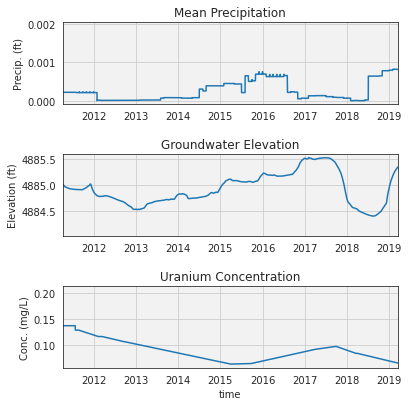




     Well  1136  smoothed data comparison

     This well is close upstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

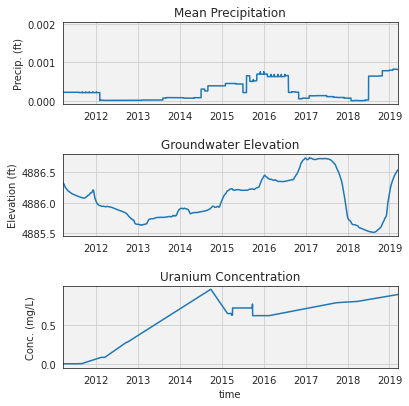




     Well  1128  smoothed data comparison

     This well is close downstream



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

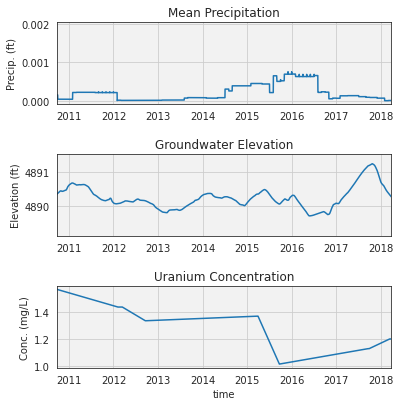

In [ ]:
# Graph Analytes in Subplots

desired_wells = ['1135','1136','1128']
all_wells = data['STATION_ID'].unique()

Analytes = data['ANALYTE_NAME'].unique()

for well_name in desired_wells: #all_wells:

  ELEV_data = tdf.query_data(well_name,'WaterElevation')
  ELEV_data = tdf.simplify_data(data=ELEV_data)
  ELEV_data['COLLECTION_DATE'] = pd.to_datetime(ELEV_data['COLLECTION_DATE'])


  URAN_data = tdf.query_data(well_name, 'Uranium')
  URAN_data = tdf.simplify_data(data=URAN_data)
  URAN_data['COLLECTION_DATE'] = pd.to_datetime(URAN_data['COLLECTION_DATE'])
  

  PRCP_data = tdf.query_data(well_name, 'Precipitation')
  PRCP_data = tdf.simplify_data(data=PRCP_data)
  PRCP_data['COLLECTION_DATE'] = pd.to_datetime(PRCP_data['COLLECTION_DATE'])


  ELEVstart = ELEV_data['COLLECTION_DATE'].iat[0]
  ELEVend = ELEV_data['COLLECTION_DATE'].iat[-1]

  URANstart = URAN_data['COLLECTION_DATE'].iat[0]
  URANend = URAN_data['COLLECTION_DATE'].iat[-1]

  PRCPstart = PRCP_data['COLLECTION_DATE'].iat[0]
  PRCPend = PRCP_data['COLLECTION_DATE'].iat[-1]

  # Select the latest start date, earliest end date

  dateframe = pd.DataFrame({'Start Date':[ELEVstart,URANstart,PRCPstart],'End Date':[ELEVend,URANend,PRCPend]})

  startdate = dateframe['Start Date'].max()
  enddate = dateframe['End Date'].min()

  if startdate >= enddate:
    print('Well ', well_name, ' is unworkable')
  else:
    print('\n     Well ', well_name, ' smoothed data comparison\n')

  if well_name in Downfar:
    print('     This well is far downstream\n')
  elif well_name in Downacc:
    print('     This well is downstream, and across\n')
  elif well_name in Downclose:
    print('     This well is close downstream\n')
  elif well_name in Upfar:
    print('     This well is far upstream\n')
  elif well_name in Upacc:
    print('     This well is upstream, and across\n')
  elif well_name in Upclose:
    print('     This well is close upstream\n')
  else:
    print('     Missed this one...')



  fig, axs = plt.subplots(3, 1)

  axs[0].title.set_text('Mean Precipitation')
  axs[0].plot(PRCP_data.COLLECTION_DATE, PRCP_data.RESULT)
  axs[0].set_xlim(startdate, enddate)
  #axs[0].set_xlabel('time')
  axs[0].set_ylabel('Precip. (ft)')
  axs[0].grid(True)

  axs[1].title.set_text('Groundwater Elevation')
  axs[1].plot(ELEV_data.COLLECTION_DATE, ELEV_data.RESULT)
  axs[1].set_xlim(startdate, enddate)
  #axs[1].set_xlabel('time')
  axs[1].set_ylabel('Elevation (ft)')
  axs[1].grid(True)
  
  axs[2].title.set_text('Uranium Concentration')
  axs[2].plot(URAN_data.COLLECTION_DATE, URAN_data.RESULT)
  axs[2].set_xlim(startdate, enddate)
  axs[2].set_xlabel('time')
  axs[2].set_ylabel('Conc. (mg/L)')
  axs[2].grid(True)



  plt.subplots_adjust(bottom = 0.1, top = 1.3, wspace=0.5, hspace=0.6)

  savepath = str(well_name)+'SmoothComparison.pdf'
  plt.savefig(savepath,bbox_inches='tight')
  files.download(savepath)

  plt.show()

  print('\n')

Smooth Correlation Figures

In [ ]:
Analytes = data['ANALYTE_NAME'].unique()

Correlation figures categorized by relative position

In [ ]:
#for well_name in Upfar:
#  tdf.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)

In [ ]:
#for well_name in Upclose:
#  tdf.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)

In [ ]:
#for well_name in Downclose:
#   tdf.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)

In [ ]:
#for well_name in Downfar:
#  tdf.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)

Report Figures

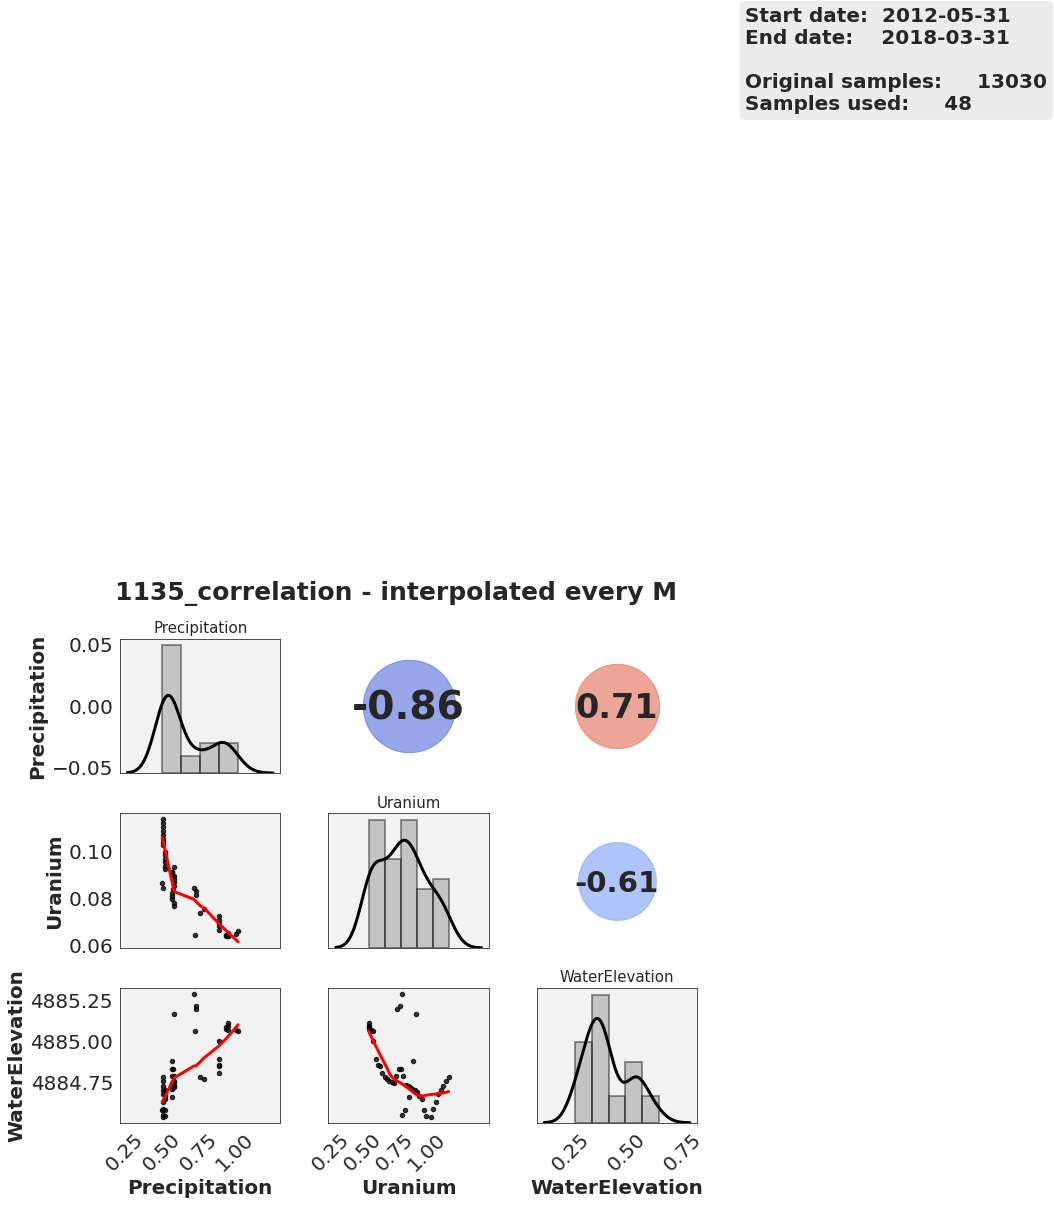

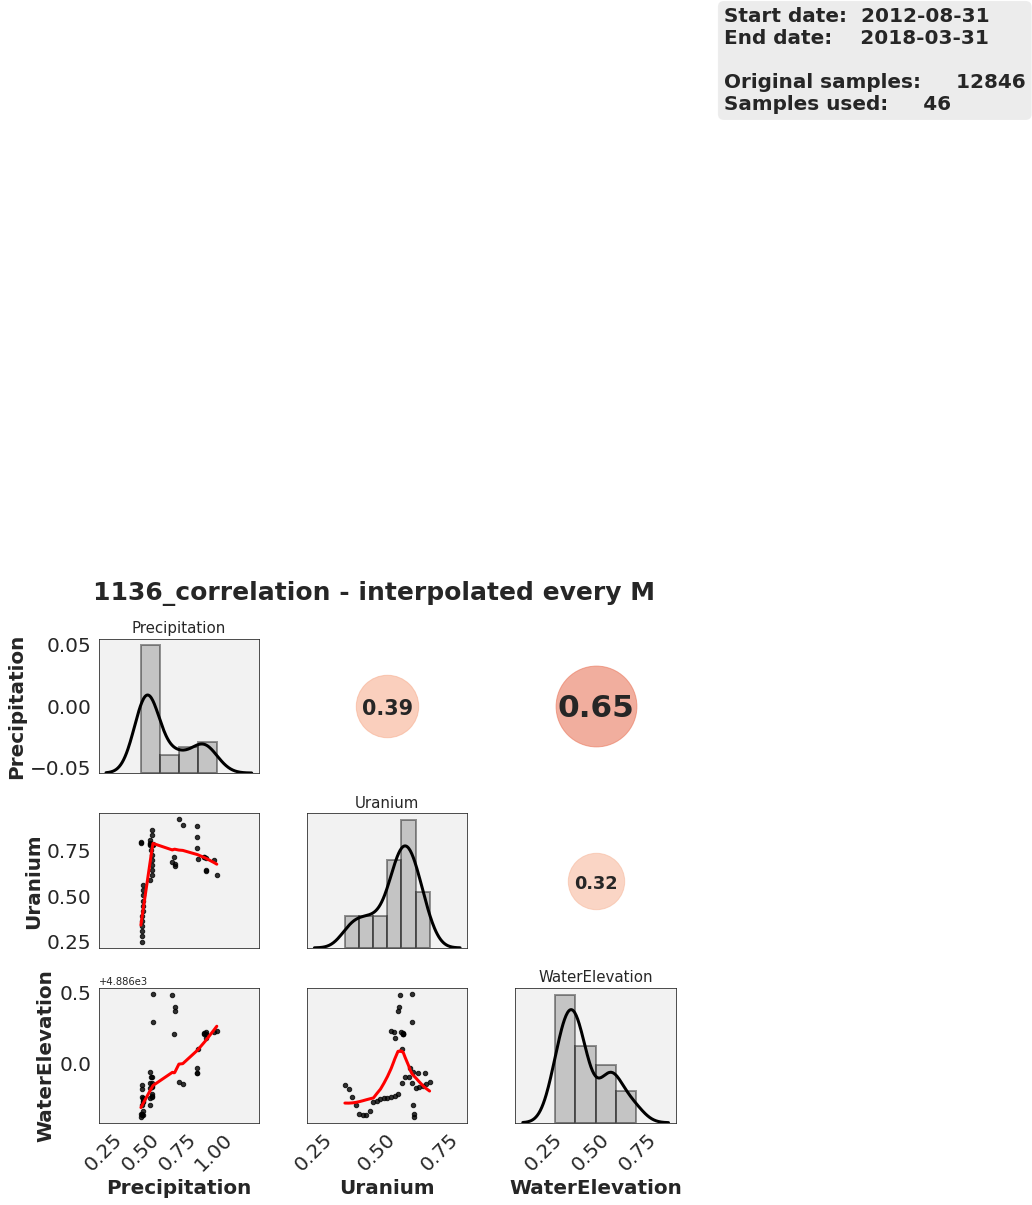

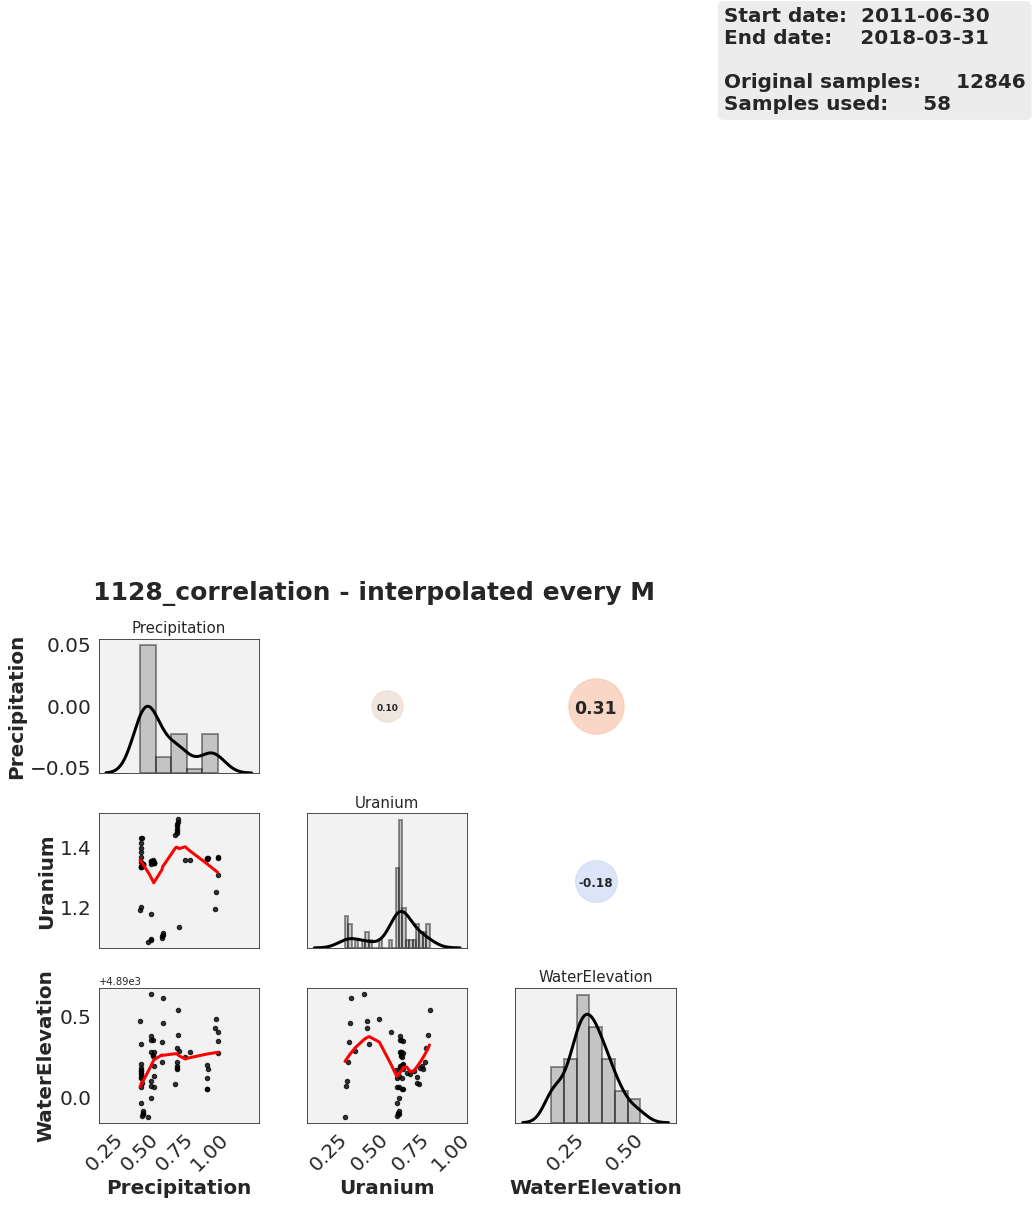

In [ ]:
#Analytes = data['ANALYTE_NAME'].unique()
#desired_wells = ['1135','1136','1128']

for well_name in desired_wells:#all_wells.astype(str):
  tdf.plot_corr_by_well(well_name=well_name, analytes=Analytes, interpolate=True, frequency='M', remove_outliers=True, z_threshold=1.3, log_transform=False)
